# Homework 02: Multi-Class Classification with Neural Networks

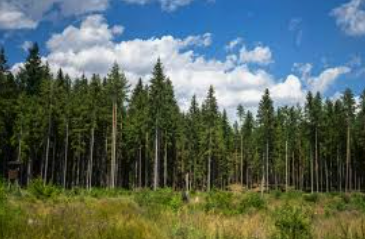

In this assignment, you’ll extend your Keras classification toolkit by training a neural network on a **balanced subset of the Forest Cover (Covertype) dataset**. We’ll begin with a simple baseline network, then study how performance changes as we vary **batch size**, **learning rate**, and apply a **cosine-decay schedule**.

For each configuration, you will consider a range of hyperparameter values, plot training/validation **loss** and **accuracy** over epochs, and determine which choice gave the best performance. 

Finally, you will consider all that you have learned and build your best model and run it on the test set. 


There are 9 graded questions, each worth 9 points, and you get 4 points for free if you complete the whole homework. 


In [1]:
# Useful imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

random_seed = 42

tf.random.set_seed(random_seed)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

$$k\cdot\sigma$$

In [2]:
# Utility function: Plotting Training Loss (categorical x-entropy) and Accuracy

# Takes the history object returned by fit

def plot_history(history):
    n_epochs = len(history.history['accuracy'])
    epochs = range(1, n_epochs + 1)

    plt.figure(figsize=(7, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss (Xent)', color='tab:red')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.title('Training Accuracy')
    plt.grid(True)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    final_loss = history.history['loss'][-1]
    final_acc = history.history['accuracy'][-1]
    print(f'Final Training Loss:     {final_loss:.4f}')
    print(f'Final Training Accuracy: {final_acc:.4f}')

## Load the dataset

The dataset is described in detail in the Appendix. For the purposes of this homework, we are selecting a random sample with 2747 samples in each class (to preserve balance), because the original dataset is both very large and very imbalanced, with the smallest class having 2747 samples. 

In [3]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np

# Load
X, y = fetch_covtype(return_X_y=True)   # y in {1..7}
classes, counts = np.unique(y, return_counts=True)
min_count = counts.min()                # size of rarest class (~2.7k)

# Build perfectly balanced subset (no replacement, no duplicates)
rng = np.random.default_rng(42)
idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = X[idx_bal]
y_sub = y[idx_bal] - 1                  # relabel to 0..6 for Keras
print("Subset shape:", X_sub.shape, "Class counts:", Counter(y_sub))


Subset shape: (19229, 54) Class counts: Counter({np.int32(3): 2747, np.int32(2): 2747, np.int32(6): 2747, np.int32(5): 2747, np.int32(4): 2747, np.int32(1): 2747, np.int32(0): 2747})


## Problem One: Prepare the dataset and build a baseline model

### Part A: Stratified train/test split and standardization

As in Homework 1, follow these three steps:

1. **Stratified split:**
   Use `train_test_split` with `stratify=y_sub` to preserve class proportions in both training and test sets. Be sure to set `random_state=random_seed` and `test_size=0.2`.

2. **Standardize features:**
   Scale the input features so they have mean 0 and variance 1.



In [4]:
# Your code here
X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.2, random_state=random_seed, stratify=y_sub)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Part B: Build, compile, train, and evaluate the network

1. **Build the model**

   * Use 2 hidden layers:  input &rarr; 64 &rarr; 32 &rarr; output.
   * Apply the `relu` activation for the hidden layers and `softmax` for the output layer.

2. **Compile the model**

    * Use the following parameters


           optimizer = Adam(learning_rate=0.0001),  
           loss = 'sparse_categorical_crossentropy',  
           metrics = ['accuracy']


4. **Train the model**

   * Run for **20 epochs**.
   * Use a `batch_size` of 32.

5. **Evaluate training**

   * Plot the training loss and accuracy curves using `plot_history`.

6. **Answer the graded questions**



Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 309us/step - accuracy: 0.3288 - loss: 1.7537
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.5602 - loss: 1.3026
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - accuracy: 0.6105 - loss: 1.0498
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.6305 - loss: 0.9384
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.6463 - loss: 0.8807
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.6586 - loss: 0.8445
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.6682 - loss: 0.8186
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.6756 - loss: 0.7983
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - accuracy: 0.6821 - loss: 0.7810
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step - accuracy: 0.6879 - loss: 0.7659
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.6924 - loss: 0.7523
Epoch 12/20
481/481 ━━━━━━━━━━

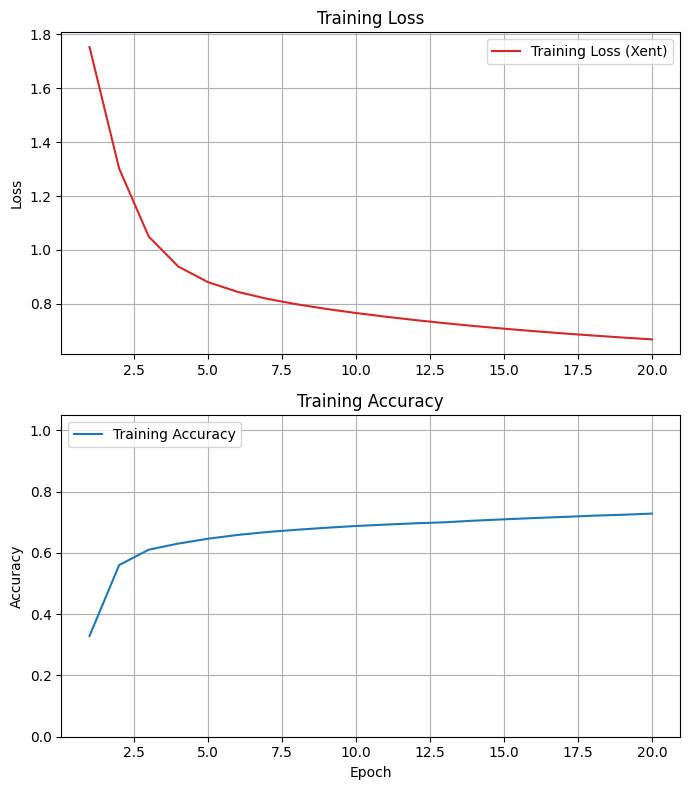

Final Training Loss:     0.6680
Final Training Accuracy: 0.7283


In [5]:
# Your code here
num_features = X_train.shape[1]
num_classes = len(np.unique(y_train))

model = Sequential([
    Input(shape=(num_features,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 20
batch_size = 32

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1)

# Plot training history
plot_history(history)

In [6]:
# Set a1a to the final training accuracy at epoch 20

a1a = history.history['accuracy'][-1]

In [7]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a:.4f}')  

a1a = 0.7283


## Problem Two: Batch Sizes

Next, we’ll explore how the **batch size** affects training. .

* Start with the code from Problem One.
* Run **four experiments** using a batch size of 4, 8, 16, and 128, and  displaying the results using `plot_history`.

* Answer the graded questions.

**Note:** Consider using a `for` loop!


Training with batch size: 4
Epoch 1/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 269us/step - accuracy: 0.5222 - loss: 1.2644
Epoch 2/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 265us/step - accuracy: 0.6469 - loss: 0.8637
Epoch 3/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 267us/step - accuracy: 0.6743 - loss: 0.7891
Epoch 4/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 277us/step - accuracy: 0.6938 - loss: 0.7470
Epoch 5/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 268us/step - accuracy: 0.7068 - loss: 0.7153
Epoch 6/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 267us/step - accuracy: 0.7188 - loss: 0.6899
Epoch 7/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 271us/step - accuracy: 0.7265 - loss: 0.6695
Epoch 8/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 265us/step - accuracy: 0.7317 - loss: 0.6526
Epoch 9/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step - accuracy: 0.7363 - loss: 0.6382
Epoch 10/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step - accuracy: 0.7412 - loss: 0.6256
Epoch 11/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 268us/step - accuracy: 0

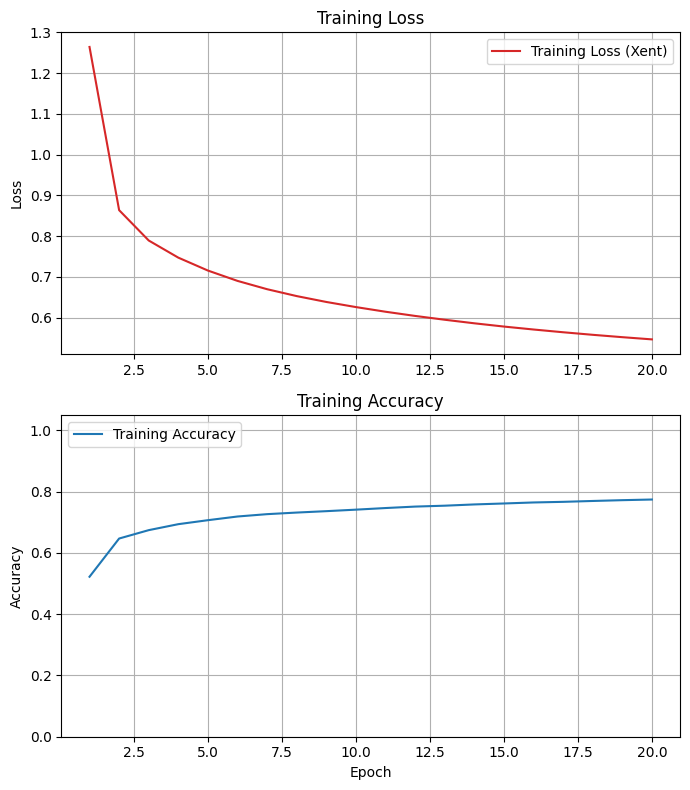

Final Training Loss:     0.5463
Final Training Accuracy: 0.7743

Training with batch size: 8
Epoch 1/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 1s 278us/step - accuracy: 0.4606 - loss: 1.4329
Epoch 2/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 1s 274us/step - accuracy: 0.6172 - loss: 0.9359
Epoch 3/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 1s 272us/step - accuracy: 0.6627 - loss: 0.8273
Epoch 4/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 1s 270us/step - accuracy: 0.6850 - loss: 0.7780
Epoch 5/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 1s 268us/step - accuracy: 0.6962 - loss: 0.7459
Epoch 6/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 1s 269us/step - accuracy: 0.7051 - loss: 0.7217
Epoch 7/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 1s 291us/step - accuracy: 0.7137 - loss: 0.7019
Epoch 8/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 1s 269us/step - accuracy: 0.7209 - loss: 0.6850
Epoch 9/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 1s 270us/step - accuracy: 0.7268 - loss: 0.6704
Epoch 10/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 1s 270us/step - accuracy: 0.7325 - loss: 0.6575
Epoch 

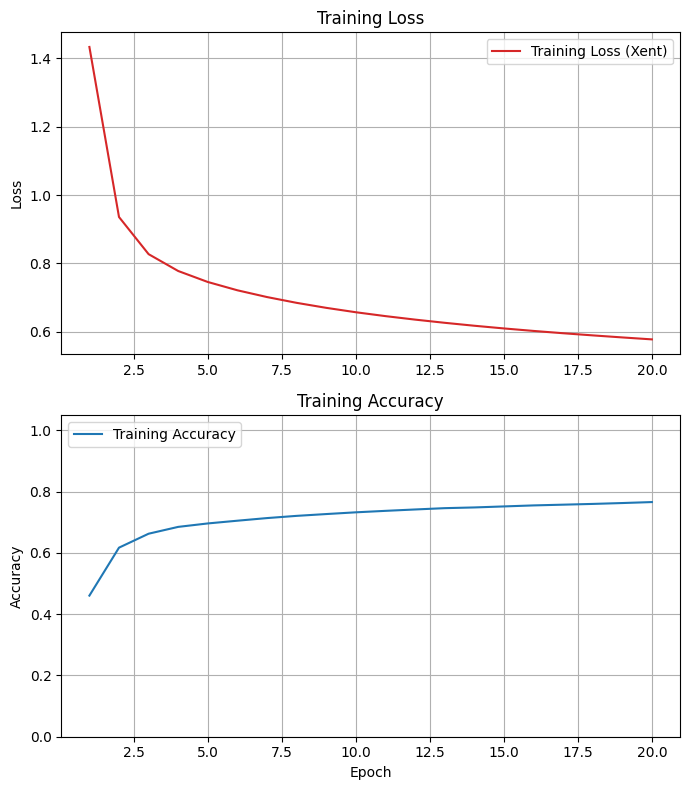

Final Training Loss:     0.5782
Final Training Accuracy: 0.7660

Training with batch size: 16
Epoch 1/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 296us/step - accuracy: 0.3887 - loss: 1.6916
Epoch 2/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step - accuracy: 0.5889 - loss: 1.0932
Epoch 3/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - accuracy: 0.6354 - loss: 0.9139
Epoch 4/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step - accuracy: 0.6577 - loss: 0.8456
Epoch 5/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step - accuracy: 0.6767 - loss: 0.8052
Epoch 6/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step - accuracy: 0.6853 - loss: 0.7761
Epoch 7/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step - accuracy: 0.6944 - loss: 0.7531
Epoch 8/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step - accuracy: 0.7025 - loss: 0.7337
Epoch 9/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step - accuracy: 0.7093 - loss: 0.7170
Epoch 10/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.7136 - loss: 0.7025
Epoch 11/20
962/962 ━━━━━

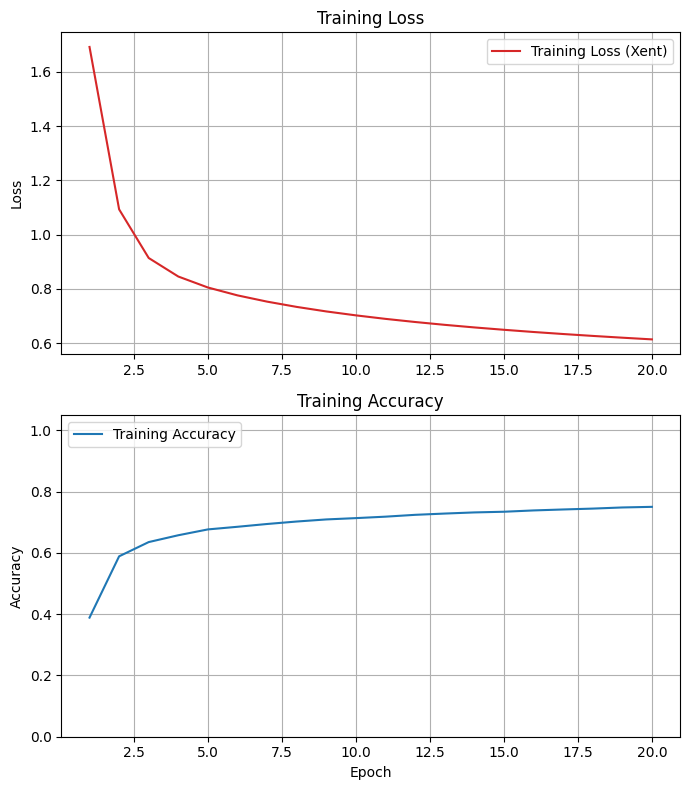

Final Training Loss:     0.6140
Final Training Accuracy: 0.7504

Training with batch size: 128
Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.2236 - loss: 1.9851 
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - accuracy: 0.3601 - loss: 1.7490
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - accuracy: 0.4648 - loss: 1.5552
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - accuracy: 0.5149 - loss: 1.3886
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - accuracy: 0.5489 - loss: 1.2521
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - accuracy: 0.5649 - loss: 1.1485
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - accuracy: 0.5837 - loss: 1.0720
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - accuracy: 0.6033 - loss: 1.0157
Epoch 9/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - accuracy: 0.6150 - loss: 0.9737
Epoch 10/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - accuracy: 0.6268 - loss: 0.9409
Epoch 11/20
121/121 ━━━

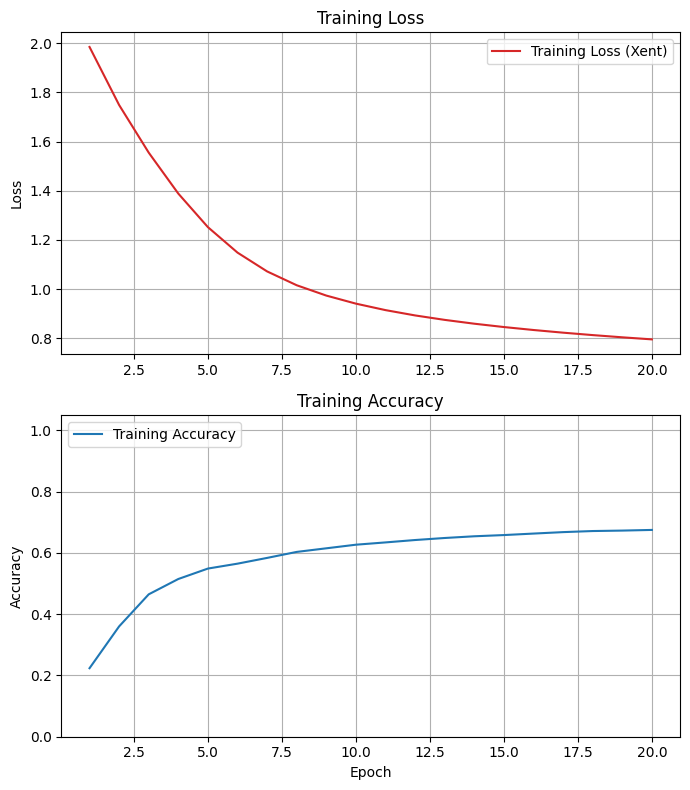

Final Training Loss:     0.7955
Final Training Accuracy: 0.6750


In [8]:
# Your code here
batch_sizes = [4, 8, 16, 128]
# Store best accuracy and corresponding batch size
best_batch_accuracy = 0.0
best_batch_size = 0
for experiment in batch_sizes:
    print(f'\nTraining with batch size: {experiment}')
    model = Sequential([
        Input(shape=(num_features,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    epochs = 20

    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=experiment,
                        verbose=1)

    # Plot training history
    plot_history(history)

    if history.history['accuracy'][-1] > best_batch_accuracy:
        best_batch_accuracy = history.history['accuracy'][-1]
        best_batch_size = experiment

In [9]:
# Set a2a to the batch size which produced the best accuracy score at epoch 20

a2a = best_batch_size

In [10]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a}') 

a2a = 4


In [11]:
# Set a2b to the best accuracy score found

a2b = best_batch_accuracy

In [12]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7743


## Problem Three: Learning Rates

Next, we’ll explore how the **learning rate** affects training when using the Adam optimizer.

* Start with the code from **Problem One**.
* Add the `learning_rate` parameter to `Adam`.
* Run **five experiments** using the following values:

        [1e-3, 5e-4, 1e-4,5e-5, 1e-5]

* Display your results using `plot_history` and answer the graded questions.



Training with learning rate: 0.001
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 311us/step - accuracy: 0.6061 - loss: 1.0008
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.6930 - loss: 0.7328
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.7216 - loss: 0.6634
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - accuracy: 0.7389 - loss: 0.6220
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.7510 - loss: 0.5944
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - accuracy: 0.7612 - loss: 0.5733
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - accuracy: 0.7673 - loss: 0.5565
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - accuracy: 0.7740 - loss: 0.5426
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.7805 - loss: 0.5297
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.7845 - loss: 0.5175
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.7890 - loss: 0

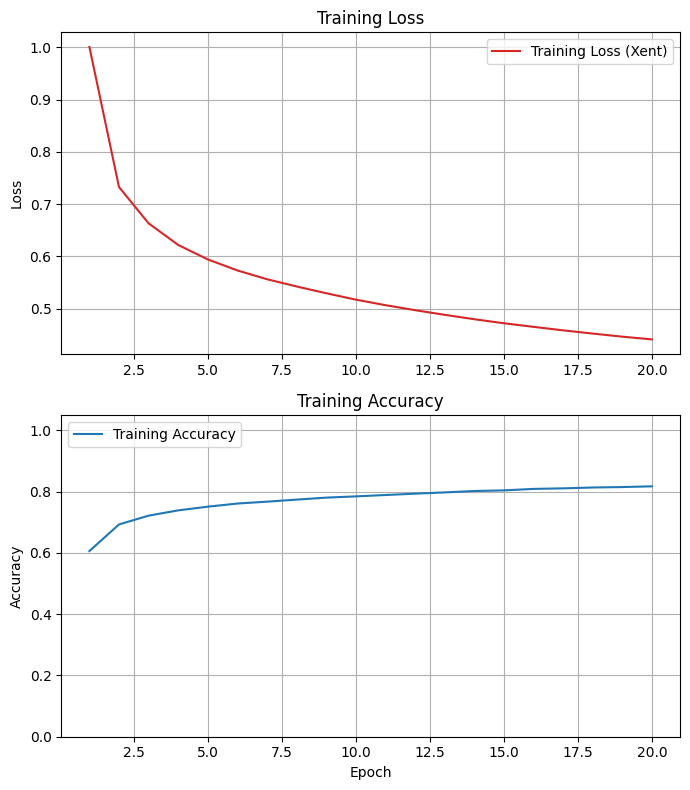

Final Training Loss:     0.4415
Final Training Accuracy: 0.8174

Training with learning rate: 0.0005
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 312us/step - accuracy: 0.5737 - loss: 1.1166
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - accuracy: 0.6713 - loss: 0.7990
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - accuracy: 0.6988 - loss: 0.7351
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.7144 - loss: 0.6917
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.7309 - loss: 0.6581
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step - accuracy: 0.7428 - loss: 0.6316
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - accuracy: 0.7502 - loss: 0.6103
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.7575 - loss: 0.5927
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - accuracy: 0.7631 - loss: 0.5777
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - accuracy: 0.7697 - loss: 0.5648
Epoch 11/20
481/48

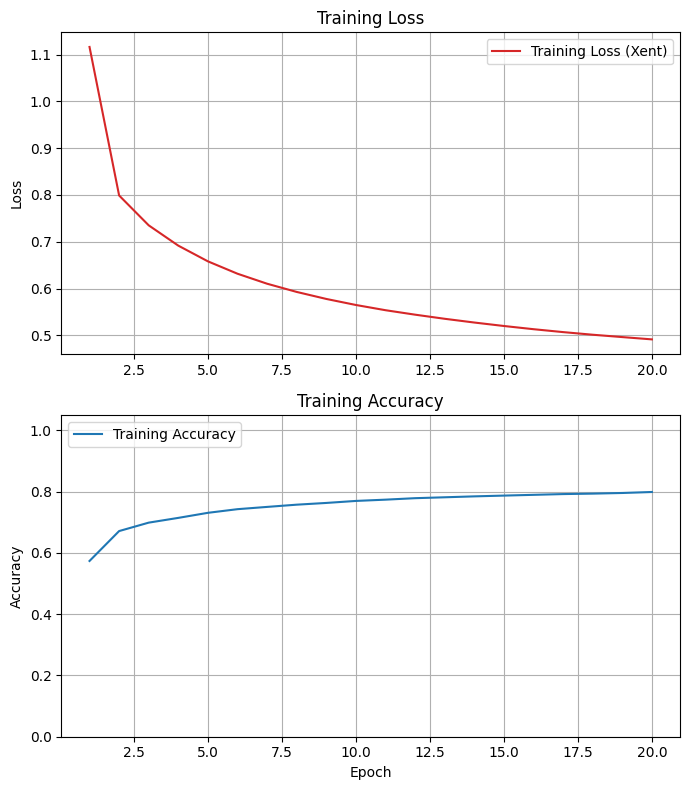

Final Training Loss:     0.4912
Final Training Accuracy: 0.7989

Training with learning rate: 0.0001
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 310us/step - accuracy: 0.3405 - loss: 1.7300
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step - accuracy: 0.5434 - loss: 1.2507
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.6010 - loss: 1.0191
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.6323 - loss: 0.9141
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.6524 - loss: 0.8612
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.6661 - loss: 0.8284
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.6748 - loss: 0.8045
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.6833 - loss: 0.7853
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.6897 - loss: 0.7689
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.6965 - loss: 0.7544
Epoch 11/20
481/48

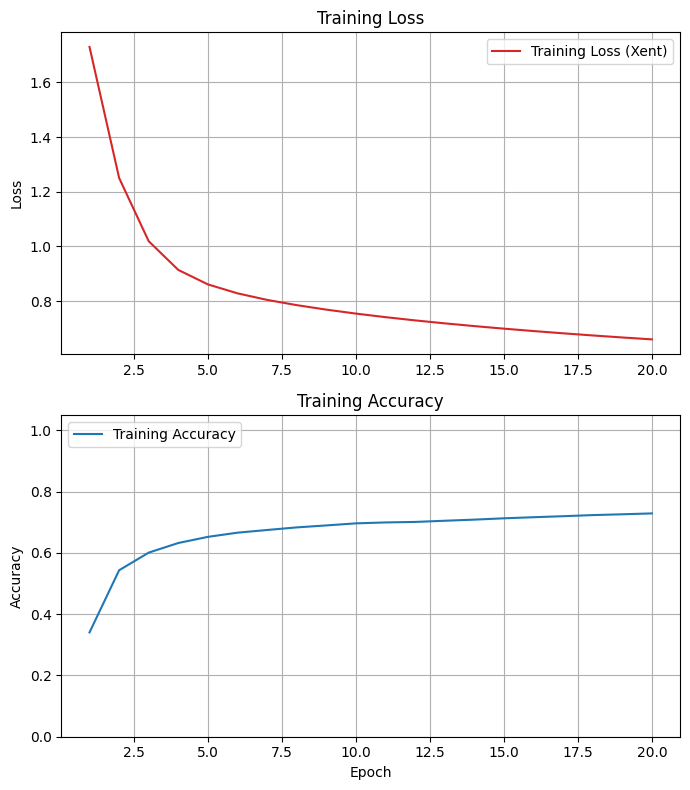

Final Training Loss:     0.6600
Final Training Accuracy: 0.7290

Training with learning rate: 5e-05
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 310us/step - accuracy: 0.2379 - loss: 2.0026
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.4368 - loss: 1.6602
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - accuracy: 0.5261 - loss: 1.4216
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.5635 - loss: 1.2402
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - accuracy: 0.5812 - loss: 1.1109
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.5965 - loss: 1.0242
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - accuracy: 0.6129 - loss: 0.9663
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.6236 - loss: 0.9259
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step - accuracy: 0.6341 - loss: 0.8959
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.6423 - loss: 0.8726
Epoch 11/20
481/481

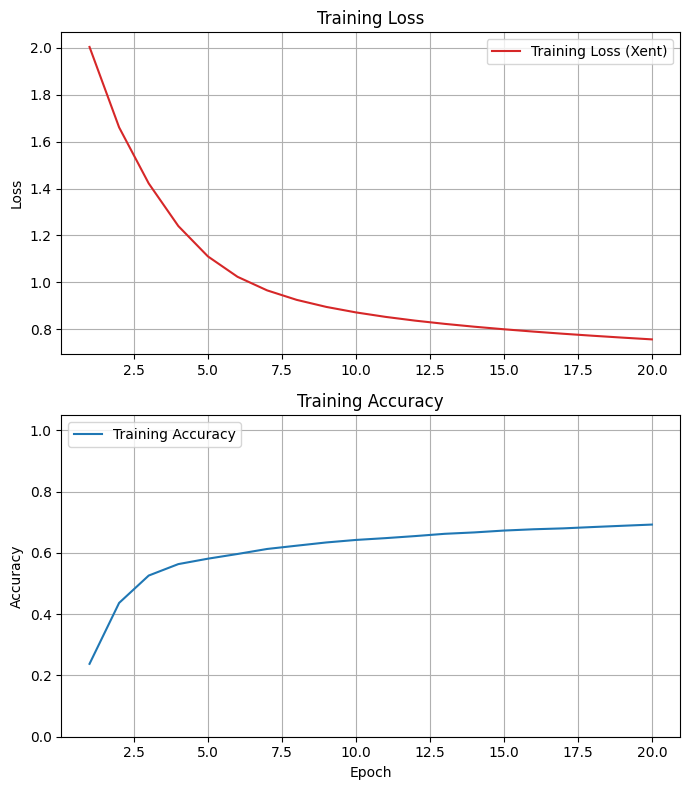

Final Training Loss:     0.7577
Final Training Accuracy: 0.6925

Training with learning rate: 1e-05
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 319us/step - accuracy: 0.1463 - loss: 2.0822
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - accuracy: 0.1953 - loss: 1.9812
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - accuracy: 0.2592 - loss: 1.8931
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.3259 - loss: 1.8147
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.3722 - loss: 1.7435
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - accuracy: 0.4066 - loss: 1.6783
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step - accuracy: 0.4298 - loss: 1.6179
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.4503 - loss: 1.5615
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.4679 - loss: 1.5084
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.4877 - loss: 1.4586
Epoch 11/20
481/481

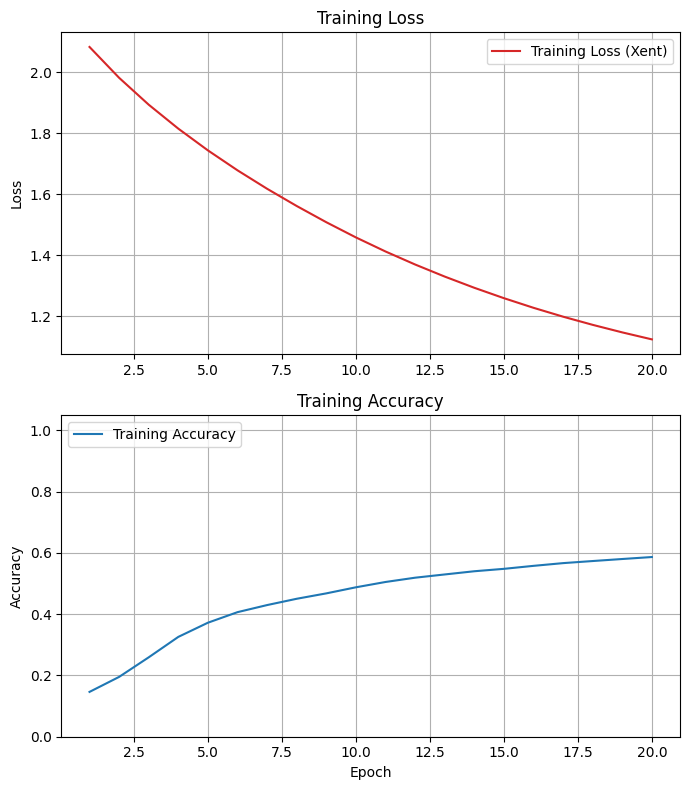

Final Training Loss:     1.1248
Final Training Accuracy: 0.5866


In [13]:
# Your code here

experiments = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
best_lr_accuracy = 0.0
best_lr = 0.0
for experiment in experiments:
    print(f'\nTraining with learning rate: {experiment}')
    model = Sequential([
    Input(shape=(num_features,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')])

    # Compile the model
    optimizer = Adam(learning_rate=experiment)
    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    # Train the model
    epochs = 20
    batch_size = 32

    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1)

    # Plot training history
    plot_history(history)

    if history.history['accuracy'][-1] > best_lr_accuracy:
        best_lr_accuracy = history.history['accuracy'][-1]
        best_lr = experiment

In [14]:
# Set a3a to the learning rate which produces the best (largest) accuracy at epoch 20

a3a = best_lr

In [15]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a:.4f}') 

a3a = 0.0010


In [16]:
# Set a3b to the accuracy found by the best learning rate

a3b = best_lr_accuracy

In [17]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.8174


## Problem Four: Cosine Decay Learning Rate Scheduling

In this problem we'll gain some experience using the Cosine Decay learning rate scheduler with Adam. 

* Start with the code from **Problem One**.
* Define a `CosineDecay` learning rate scheduler (see `Week02_Coding.ipynb` for details)
* Use the scheduler with the Adam optimzier
* Run **five experiments** using the following values for `initial_learning_rate`:

        [1e-2, 5e-3, 1e-3,5e-4, 1e-4]

* Display your results using `plot_history` and answer the graded questions.


Training with initial learning rate: 0.01
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 310us/step - accuracy: 0.6601 - loss: 0.8135
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.7231 - loss: 0.6690
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.7449 - loss: 0.6235
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.7521 - loss: 0.5981
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.7667 - loss: 0.5639
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.7787 - loss: 0.5359
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step - accuracy: 0.7887 - loss: 0.5167
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step - accuracy: 0.8032 - loss: 0.4883
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - accuracy: 0.8102 - loss: 0.4706
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - accuracy: 0.8208 - loss: 0.4449
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - accuracy: 0.8277 - 

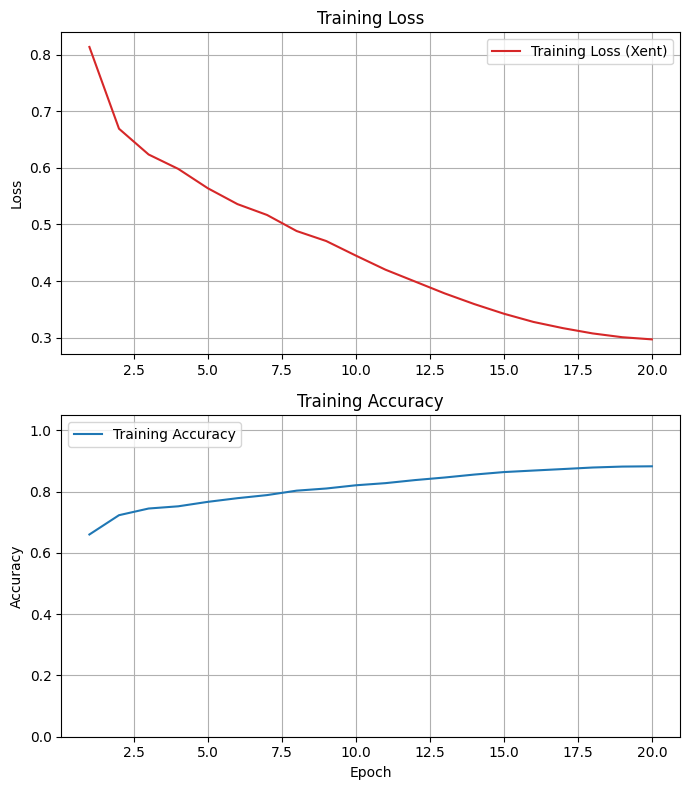

Final Training Loss:     0.2969
Final Training Accuracy: 0.8827

Training with initial learning rate: 0.005
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 310us/step - accuracy: 0.6592 - loss: 0.8256
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.7254 - loss: 0.6501
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.7508 - loss: 0.5966
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.7649 - loss: 0.5628
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - accuracy: 0.7775 - loss: 0.5377
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.7892 - loss: 0.5093
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.7995 - loss: 0.4875
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - accuracy: 0.8101 - loss: 0.4632
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.8172 - loss: 0.4434
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - accuracy: 0.8255 - loss: 0.4227
Epoch 11/20

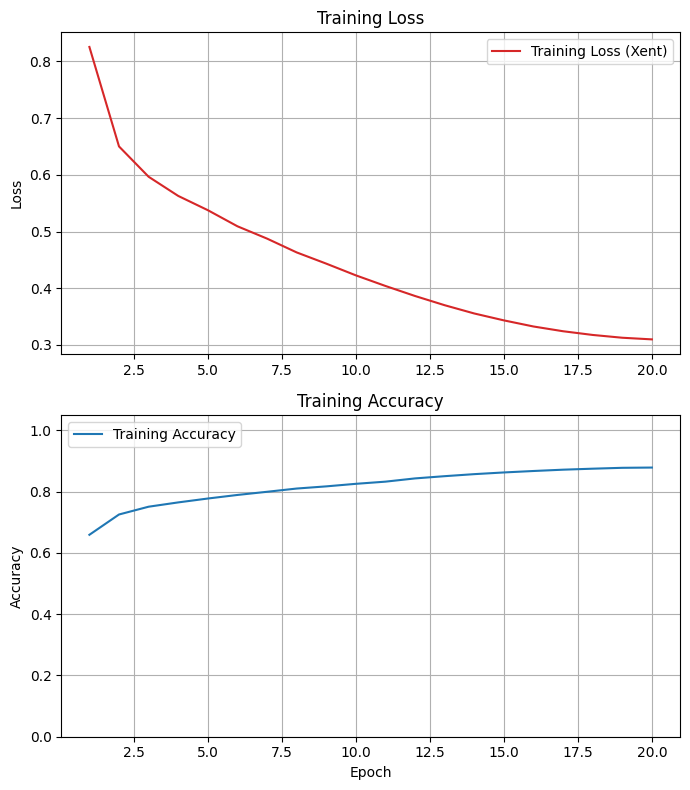

Final Training Loss:     0.3097
Final Training Accuracy: 0.8786

Training with initial learning rate: 0.001
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 318us/step - accuracy: 0.5923 - loss: 1.0321
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.7004 - loss: 0.7267
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - accuracy: 0.7275 - loss: 0.6577
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.7437 - loss: 0.6181
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step - accuracy: 0.7547 - loss: 0.5899
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - accuracy: 0.7649 - loss: 0.5681
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.7722 - loss: 0.5506
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.7782 - loss: 0.5360
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.7851 - loss: 0.5236
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.7902 - loss: 0.5129
Epoch 11/20

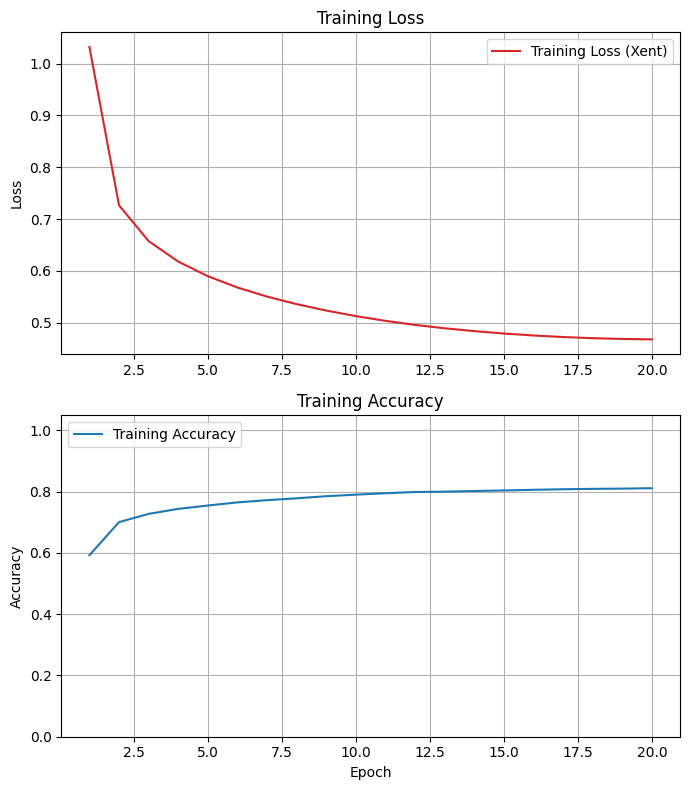

Final Training Loss:     0.4680
Final Training Accuracy: 0.8112

Training with initial learning rate: 0.0005
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 313us/step - accuracy: 0.5427 - loss: 1.1746
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.6689 - loss: 0.8029
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.7013 - loss: 0.7284
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - accuracy: 0.7193 - loss: 0.6835
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.7304 - loss: 0.6519
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.7411 - loss: 0.6280
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.7477 - loss: 0.6090
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.7554 - loss: 0.5936
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.7614 - loss: 0.5810
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.7649 - loss: 0.5707
Epoch 11/2

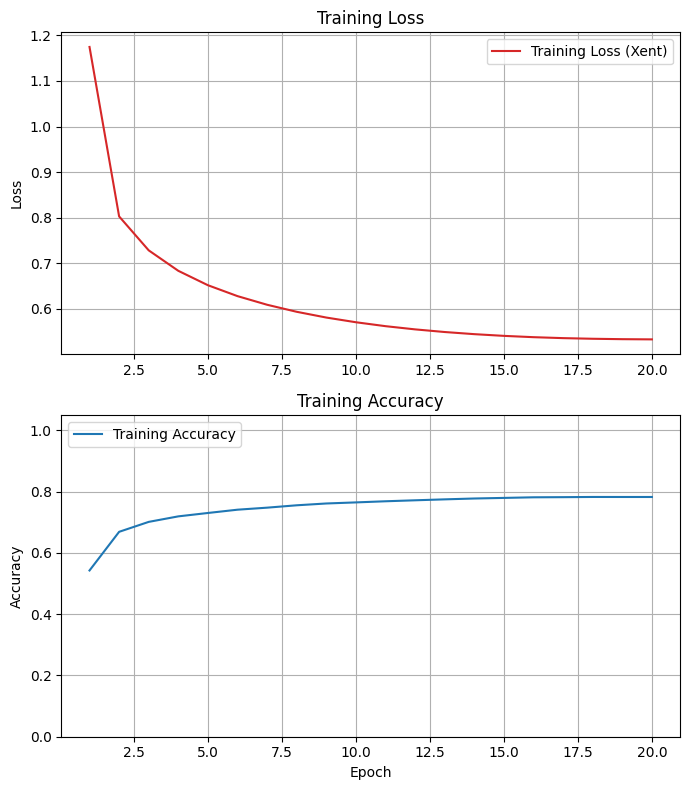

Final Training Loss:     0.5331
Final Training Accuracy: 0.7826

Training with initial learning rate: 0.0001
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 312us/step - accuracy: 0.3449 - loss: 1.7647
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - accuracy: 0.5598 - loss: 1.2877
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - accuracy: 0.6176 - loss: 1.0398
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - accuracy: 0.6361 - loss: 0.9350
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.6498 - loss: 0.8824
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - accuracy: 0.6594 - loss: 0.8490
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step - accuracy: 0.6682 - loss: 0.8255
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - accuracy: 0.6740 - loss: 0.8079
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.6804 - loss: 0.7941
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.6852 - loss: 0.7830
Epoch 11/2

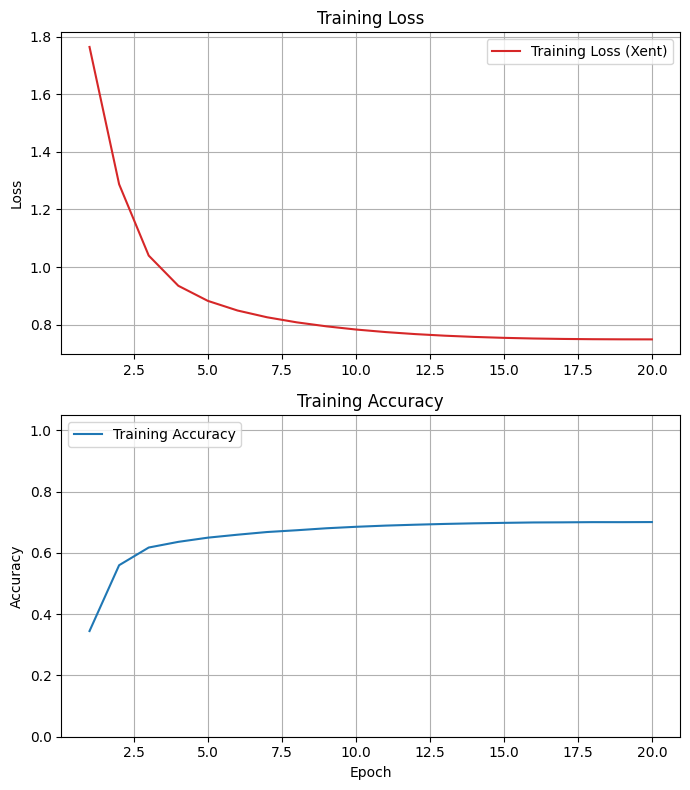

Final Training Loss:     0.7487
Final Training Accuracy: 0.7007


In [18]:
# Your code here

experiments = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
best_ilr_accuracy = 0.0
best_ilr = 0.0
for experiment in experiments:
    print(f'\nTraining with initial learning rate: {experiment}')

    # Compute the number of steps (batches) per epoch

    steps_per_epoch = int(np.ceil(len(X_train) / batch_size))

    # Total number of training steps (needed for per-step schedulers like CosineDecay)

    total_steps = epochs * steps_per_epoch
    initial_lr = experiment

    # CosineDecay schedule (per-step)
    lr_schedule = CosineDecay(
        initial_learning_rate=initial_lr,
        decay_steps=total_steps,
        alpha=0.0  # Final LR = 0
    )

    model = Sequential([
    Input(shape=(num_features,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')])

    # Compile the model
    optimizer = Adam(learning_rate=experiment)
    model.compile(optimizer=Adam(learning_rate=lr_schedule),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    # Train the model
    epochs = 20
    batch_size = 32

    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1)

    # Plot training history
    plot_history(history)

    if history.history['accuracy'][-1] > best_ilr_accuracy:
        best_ilr_accuracy = history.history['accuracy'][-1]
        best_ilr = experiment

In [19]:
# Set a4a to the initial learning rate which produced the best accuracy

a4a = best_ilr

In [20]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a:.4f}') 

a4a = 0.0100


In [21]:
# Set a4b to the best accuracy found

a4b = best_ilr_accuracy

In [22]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.8827


## Problem Five: Find the best model and run on the test set

In this final problem, you must consider all the experiments you've done and pick the
set of training hyperparameters which gives you the best accuracy after 20 epochs. Do not change the model architecture. 

Your choices are:

- Which batch size?
- Cosine Decay or constant learning rate?
    - If Cosine Decay, which initial learning rate?
    - If not, which constant learning rate?

* Display your results using `plot_history`
* Run your best model on the test set
* Answer the graded questions.


**OPTIONAL: change the model architecture (but use only dense layers) and try other learning rate schedulers (exponential, step, etc.)**

Epoch 1/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 278us/step - accuracy: 0.6278 - loss: 0.9041
Epoch 2/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 275us/step - accuracy: 0.6817 - loss: 0.7767
Epoch 3/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 277us/step - accuracy: 0.7023 - loss: 0.7348
Epoch 4/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 274us/step - accuracy: 0.7112 - loss: 0.7122
Epoch 5/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 274us/step - accuracy: 0.7252 - loss: 0.6900
Epoch 6/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 278us/step - accuracy: 0.7335 - loss: 0.6652
Epoch 7/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 275us/step - accuracy: 0.7398 - loss: 0.6478
Epoch 8/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 280us/step - accuracy: 0.7490 - loss: 0.6226
Epoch 9/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 275us/step - accuracy: 0.7611 - loss: 0.5991
Epoch 10/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 275us/step - accuracy: 0.7711 - loss: 0.5681
Epoch 11/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 274us/step - accuracy: 0.7781 - loss: 0.5480
Epoch 12

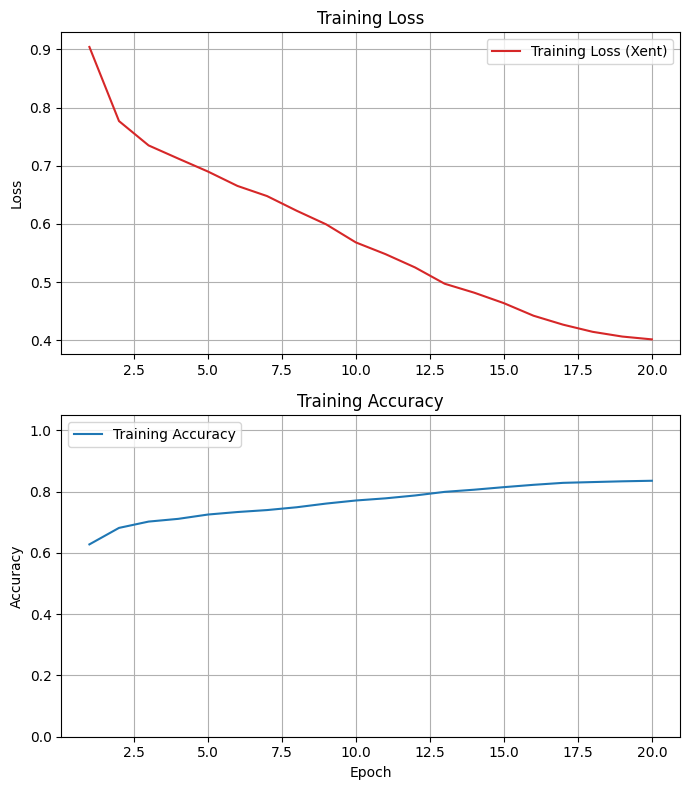

Final Training Loss:     0.4014
Final Training Accuracy: 0.8355


In [23]:
# Your code here -- add as many cells as you need

# Compute the number of steps (batches) per epoch

steps_per_epoch = int(np.ceil(len(X_train) / best_batch_size))

# Total number of training steps (needed for per-step schedulers like CosineDecay)

total_steps = epochs * steps_per_epoch

# CosineDecay schedule (per-step)
lr_schedule = CosineDecay(
    initial_learning_rate=best_ilr,
    decay_steps=total_steps,
    alpha=0.0  # Final LR = 0
)

model = Sequential([
Input(shape=(num_features,)),
Dense(64, activation='relu'),
Dense(32, activation='relu'),
Dense(num_classes, activation='softmax')])

# Compile the model
optimizer = Adam(learning_rate=best_ilr)
model.compile(optimizer=Adam(learning_rate=lr_schedule),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

# Train the model
epochs = 20
batch_size = best_batch_size

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1)

# Plot training history
plot_history(history)

best_model_train_accuracy = history.history['accuracy'][-1]
best_model_test_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]



In [24]:
# Set a5a to the best training accuracy found by your best model

a5a = best_model_train_accuracy

In [25]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5a = {a5a:.4f}') 

a5a = 0.8355


In [26]:
# Set a5b to the test accuracy found by your best model

a5b = best_model_test_accuracy

In [27]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5b = {a5b:.4f}') 

a5b = 0.7988


## Reflection Questions (ungraded)

1. We trained on a perfectly balanced \~3.3% subset.
   If we *increase the subset size* (still balanced), how would you expect (a) training time, (b) the best **batch size**, and (c) the best **learning rate** to change? Why?

2. **Batch size trade-offs.**
   With epochs fixed, why do smaller batches often generalize better on tabular data than large batches? What would you change if you *must* use a large batch?

3. **More epochs, same LR.**
    If you doubled the number of epochs (no other changes), what do you think would happen to train loss/acc and test acc? 

4. **Epochs vs. LR.**
   It is natural to think that there is an inverse relationship between the number of epochs and learning rate: if you move more slowly, it will take you longer to reach your goal. Does this seem true given what we have seen in the experiments with learning rate?

# Appendix:  Forest Cover Type (Covertype) — Dataset Overview

This dataset pairs **cartographic features** of 30×30 m land plots with the **dominant tree cover type**. Your task is to predict the cover type from terrain and soil indicators—an archetypal **multi-class classification** problem on tabular data.

**At a glance**

* **Samples:** 581,012 original; we’ll use a **balanced subset** (e.g., 2747 per class) for faster, fairer training.
* **Features (54 total):**

  * **10 continuous:** elevation, aspect, slope, distances to hydrology/roads/fire points, and hillshade at 9 AM/noon/3 PM.
  * **44 binary:** **4 Wilderness\_Area** flags and **40 Soil\_Type** one-hot indicators.
* **Target (7 classes):** Spruce/Fir, Lodgepole Pine, Ponderosa Pine, Cottonwood/Willow, Aspen, Douglas-fir, Krummholz.

**Why it’s useful here**

* Realistic, **tabular** data with mixed feature types.
* Clear demonstration of **scaling** (continuous features) vs. **binary indicators**.
* Originally **imbalanced**, which motivates mindful evaluation (we avoid this by using a balanced subset).


Shape: (19229, 55)

Class distribution:
 Cover_Type
3    0.142857
2    0.142857
6    0.142857
5    0.142857
4    0.142857
1    0.142857
0    0.142857
Name: proportion, dtype: float64


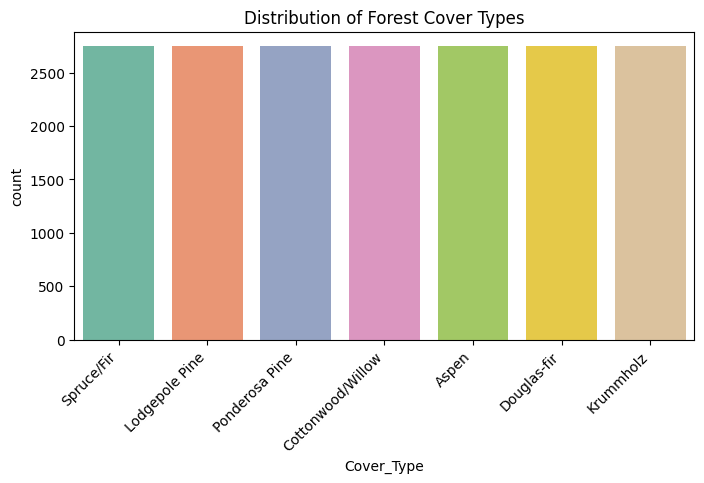

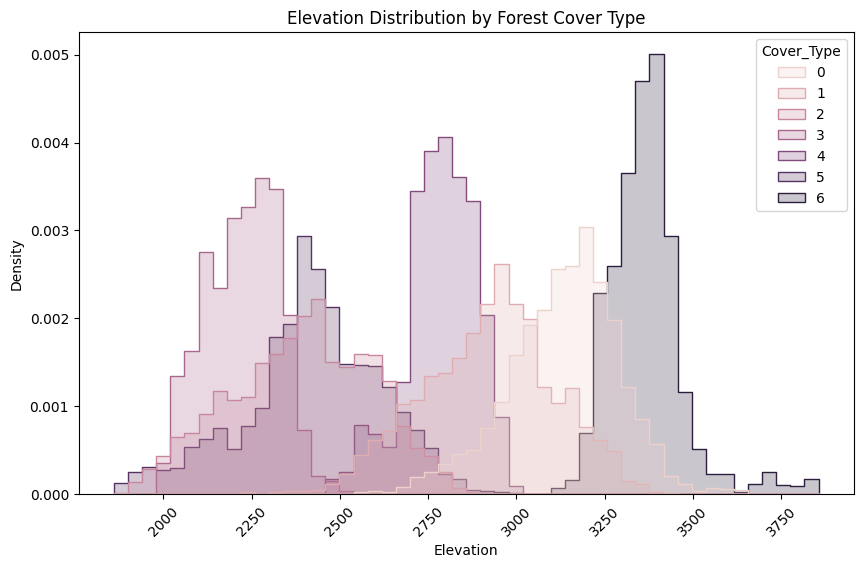

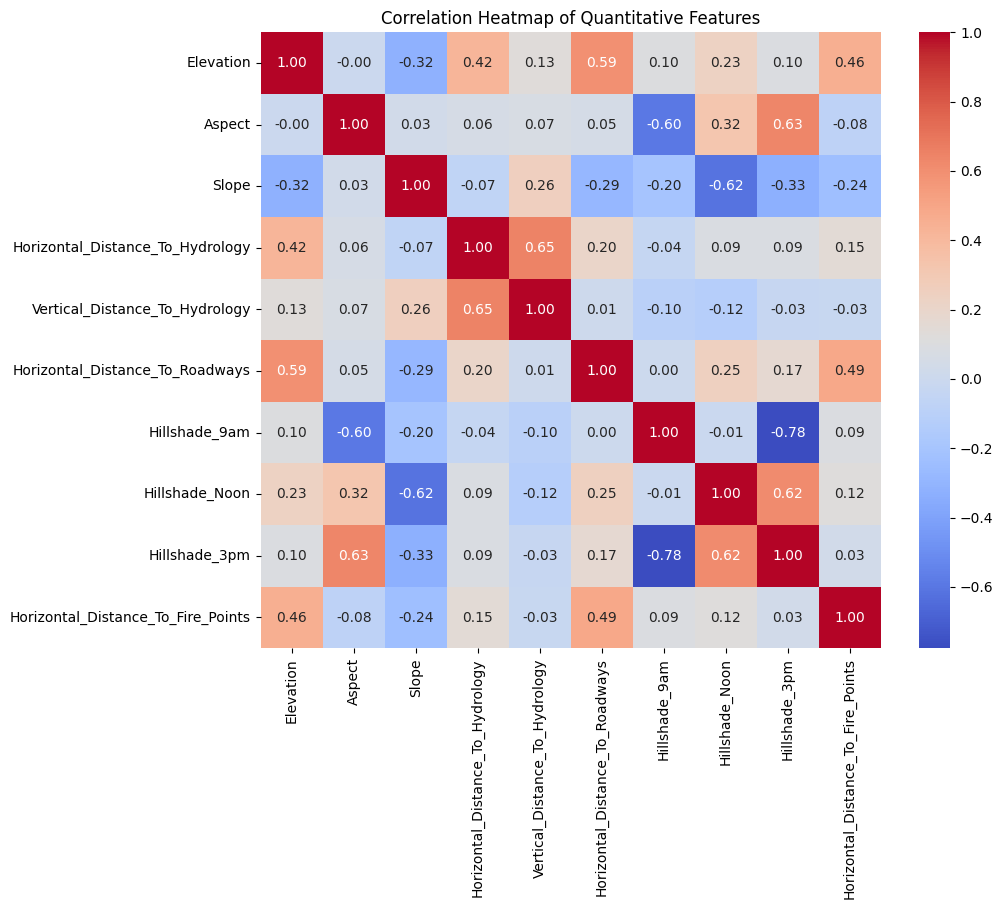

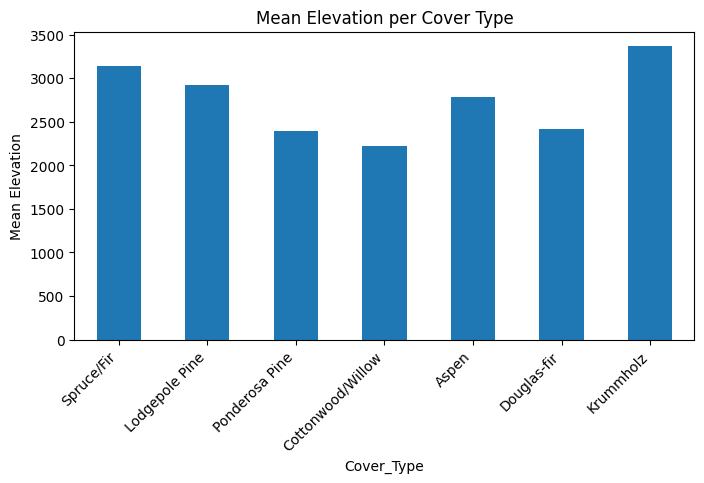

In [28]:
# Attach feature + class names
quant_features = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]
wilderness_features = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_features = [f"Soil_Type{i}" for i in range(1, 41)]

feature_names = quant_features + wilderness_features + soil_features
class_names = [
    "Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine",
    "Cottonwood/Willow", "Aspen", "Douglas-fir", "Krummholz"
]

# Create dataframe from your subset
df = pd.DataFrame(X_sub, columns=feature_names)
df["Cover_Type"] = y_sub

# 1. Basic info
print("Shape:", df.shape)
print("\nClass distribution:\n", df["Cover_Type"].value_counts(normalize=True))

# 2. Class distribution plot
plt.figure(figsize=(8,4))
sns.countplot(x="Cover_Type", hue="Cover_Type", data=df, palette="Set2", legend=False)
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.title("Distribution of Forest Cover Types")
plt.show()

# 3. Elevation distribution by class
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="Elevation", hue="Cover_Type",
             bins=50, element="step", stat="density", common_norm=False)
plt.xticks(rotation=45)
plt.title("Elevation Distribution by Forest Cover Type")
plt.show()

# 4. Correlation heatmap (quantitative features only)
plt.figure(figsize=(10,8))
corr = df[quant_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Quantitative Features")
plt.show()

# 5. Mean elevation per cover type
df.groupby("Cover_Type")["Elevation"].mean().plot(kind="bar", figsize=(8,4))
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.ylabel("Mean Elevation")
plt.title("Mean Elevation per Cover Type")
plt.show()
